# EGCI 425 - Step 4: Classification

**Dataset:** 231 movies, 11 features

**Target:** Rating_Label (Poor/Average/Good)

**Classifiers:**
1. **Decision Tree (J48/C4.5)**
2. **Support Vector Machine (SVM)**
3. **Random Forest**

---
## 1. Import Libraries and Load Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classification models
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (
    cross_val_score, cross_validate, StratifiedKFold,
    GridSearchCV, train_test_split
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set random seed
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [45]:
# Load preprocessed data
file_path = 'dataset/step2_preprocessed_data_scaled.csv'
#file_path = 'dataset/2014 and 2015 CSM dataset.xlsx'
# file_path = 'dataset/step3_data_majority_features.csv'


df = pd.read_csv(file_path)
# df = pd.read_excel(file_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst few rows:")
df.head()

Dataset loaded successfully!
Shape: 231 rows × 14 columns

First few rows:


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,-0.6459,6.3000,0.6390,-0.8248,-0.8234,-1.5273,-0.3723,-0.4024,-0.0791,-0.4991,-0.2047,-0.4296,-0.3662
1,22 Jump Street,-0.6459,7.1000,-1.0548,1.5629,0.0483,0.7481,0.6638,-0.1160,-0.7795,-0.5938,-0.4979,-0.6159,2.2618
2,3 Days to Kill,-0.6459,6.2000,-1.0548,-0.4431,-0.3686,0.4453,-0.3723,-0.4024,-0.8518,-0.8484,-0.5197,-0.6734,-0.5153
3,300: Rise of an Empire,-0.6459,6.3000,-1.0548,0.4934,1.1854,0.8626,0.6638,-0.4024,-0.8133,-0.6779,-0.4407,-0.4486,-0.4954
4,A Haunted House 2,-0.6459,4.7000,0.6390,-0.6098,-0.8329,0.0532,0.6638,-0.4024,-0.1141,0.1123,-0.0556,-0.2449,-0.1781


---
## 2. Create Target Variable and Prepare Data

In [48]:
print("CREATING CLASSIFICATION TARGET")

# Create Rating_Label from Ratings (Experiment 1b)
def assign_rating_label(rating):
    if rating < 4.9:
        return 'Poor'
    elif rating < 6.5:
        return 'Average'
    elif rating < 8.9:
        return 'Good'
    else:
        return 'Excellent'

df['Rating_Label'] = df['Ratings'].apply(assign_rating_label)

print("\nRating_Label created")
print("\nClass Distribution:")
for label in ['Poor', 'Average', 'Good', 'Excellent']:
    if label in df['Rating_Label'].value_counts().index:
        count = df['Rating_Label'].value_counts()[label]
        pct = (count/len(df))*100
        print(f"  {label:10s}: {count:3d} movies ({pct:5.1f}%)")

print(f"\nTotal: {len(df)} movies")
print(f"Number of classes: {df['Rating_Label'].nunique()}")

df.head()

CREATING CLASSIFICATION TARGET

Rating_Label created

Class Distribution:
  Poor      :  17 movies (  7.4%)
  Average   :  94 movies ( 40.7%)
  Good      : 120 movies ( 51.9%)

Total: 231 movies
Number of classes: 3


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers,Rating_Label
0,13 Sins,-0.6459,6.3000,0.6390,-0.8248,-0.8234,-1.5273,-0.3723,-0.4024,-0.0791,-0.4991,-0.2047,-0.4296,-0.3662,Average
1,22 Jump Street,-0.6459,7.1000,-1.0548,1.5629,0.0483,0.7481,0.6638,-0.1160,-0.7795,-0.5938,-0.4979,-0.6159,2.2618,Good
2,3 Days to Kill,-0.6459,6.2000,-1.0548,-0.4431,-0.3686,0.4453,-0.3723,-0.4024,-0.8518,-0.8484,-0.5197,-0.6734,-0.5153,Average
3,300: Rise of an Empire,-0.6459,6.3000,-1.0548,0.4934,1.1854,0.8626,0.6638,-0.4024,-0.8133,-0.6779,-0.4407,-0.4486,-0.4954,Average
4,A Haunted House 2,-0.6459,4.7000,0.6390,-0.6098,-0.8329,0.0532,0.6638,-0.4024,-0.1141,0.1123,-0.0556,-0.2449,-0.1781,Poor


In [49]:
print("PREPARING FEATURES AND TARGET")

# Exclude columns
# - Movie: identifier
# - Ratings: used to create Rating_Label
# - Rating_Label: our target
# SMF = 1. Aggregate Actor Followers 2. Number of  views  3. Number of  likes 4. Number of  dislikes  5. Number of  comments 6. Sentiment Score
exclude_cols = ['Movie', 'Ratings','Rating_Label']
feature_cols = [col for col in df.columns if col not in exclude_cols]
# feature_cols = ['Aggregate Followers', 'Views', 'Likes', 'Dislikes',  'Comments', 'Sentiment']

X = df[feature_cols]
y = df['Rating_Label']

print(f"\nFeatures (X): {X.shape}")
print(f"  Columns ({len(feature_cols)}): {feature_cols}")

print(f"\nTarget (y): {y.shape}")
print(f"  Variable: Rating_Label")
print(f"  Classes: {sorted(y.unique())}")

# Encode labels for sklearn
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nLabel Encoding:")
for i, label in enumerate(le.classes_):
    print(f"  {label} → {i}")

X.head()

PREPARING FEATURES AND TARGET

Features (X): (231, 12)
  Columns (12): ['Year', 'Genre', 'Gross', 'Budget', 'Screens', 'Sequel', 'Sentiment', 'Views', 'Likes', 'Dislikes', 'Comments', 'Aggregate Followers']

Target (y): (231,)
  Variable: Rating_Label
  Classes: ['Average', 'Good', 'Poor']

Label Encoding:
  Average → 0
  Good → 1
  Poor → 2


,Year,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,-0.6459,0.6390,-0.8248,-0.8234,-1.5273,-0.3723,-0.4024,-0.0791,-0.4991,-0.2047,-0.4296,-0.3662
1,-0.6459,-1.0548,1.5629,0.0483,0.7481,0.6638,-0.1160,-0.7795,-0.5938,-0.4979,-0.6159,2.2618
2,-0.6459,-1.0548,-0.4431,-0.3686,0.4453,-0.3723,-0.4024,-0.8518,-0.8484,-0.5197,-0.6734,-0.5153
3,-0.6459,-1.0548,0.4934,1.1854,0.8626,0.6638,-0.4024,-0.8133,-0.6779,-0.4407,-0.4486,-0.4954
4,-0.6459,0.6390,-0.6098,-0.8329,0.0532,0.6638,-0.4024,-0.1141,0.1123,-0.0556,-0.2449,-0.1781


---
## 3. Classifier #1: Decision Tree (J48/C4.5)

In [50]:
print("CLASSIFIER #1: DECISION TREE")

# Define parameter grid for tuning
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

print("\nParameter grid for tuning:")
for param, values in dt_param_grid.items():
    print(f"  {param}: {values}")

# Setup stratified cross-validation
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X, y_encoded)

print(f"\nBest Parameters:")
for param, value in dt_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Accuracy: {dt_grid.best_score_:.4f}")

dt_best = dt_grid.best_estimator_

CLASSIFIER #1: DECISION TREE

Parameter grid for tuning:
  max_depth: [3, 5, 7, 10, None]
  min_samples_split: [2, 5, 10, 20]
  min_samples_leaf: [1, 2, 5, 10]
  criterion: ['gini', 'entropy']
Fitting 10 folds for each of 160 candidates, totalling 1600 fits

Best Parameters:
  criterion: entropy
  max_depth: 3
  min_samples_leaf: 10
  min_samples_split: 2

Best Cross-Validation Accuracy: 0.6226


In [51]:
# Detailed cross-validation evaluation
print("DECISION TREE: DETAILED 10-FOLD CV EVALUATION")

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Perform cross-validation
dt_cv_results = cross_validate(
    dt_best, X, y_encoded,
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=True
)

print("\nCross-Validation Results (10 folds):")
print("-" * 60)

metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
results_dt = {}

for metric in metrics:
    test_scores = dt_cv_results[f'test_{metric}']
    mean_score = test_scores.mean()
    std_score = test_scores.std()
    results_dt[metric] = {'mean': mean_score, 'std': std_score}
    
    print(f"{metric.upper():20s}: {mean_score:.4f} (+/- {std_score:.4f})")

DECISION TREE: DETAILED 10-FOLD CV EVALUATION

Cross-Validation Results (10 folds):
------------------------------------------------------------
ACCURACY            : 0.6226 (+/- 0.1227)
PRECISION_MACRO     : 0.4567 (+/- 0.1579)
RECALL_MACRO        : 0.4630 (+/- 0.1118)
F1_MACRO            : 0.4506 (+/- 0.1267)


DECISION TREE VISUALIZATION


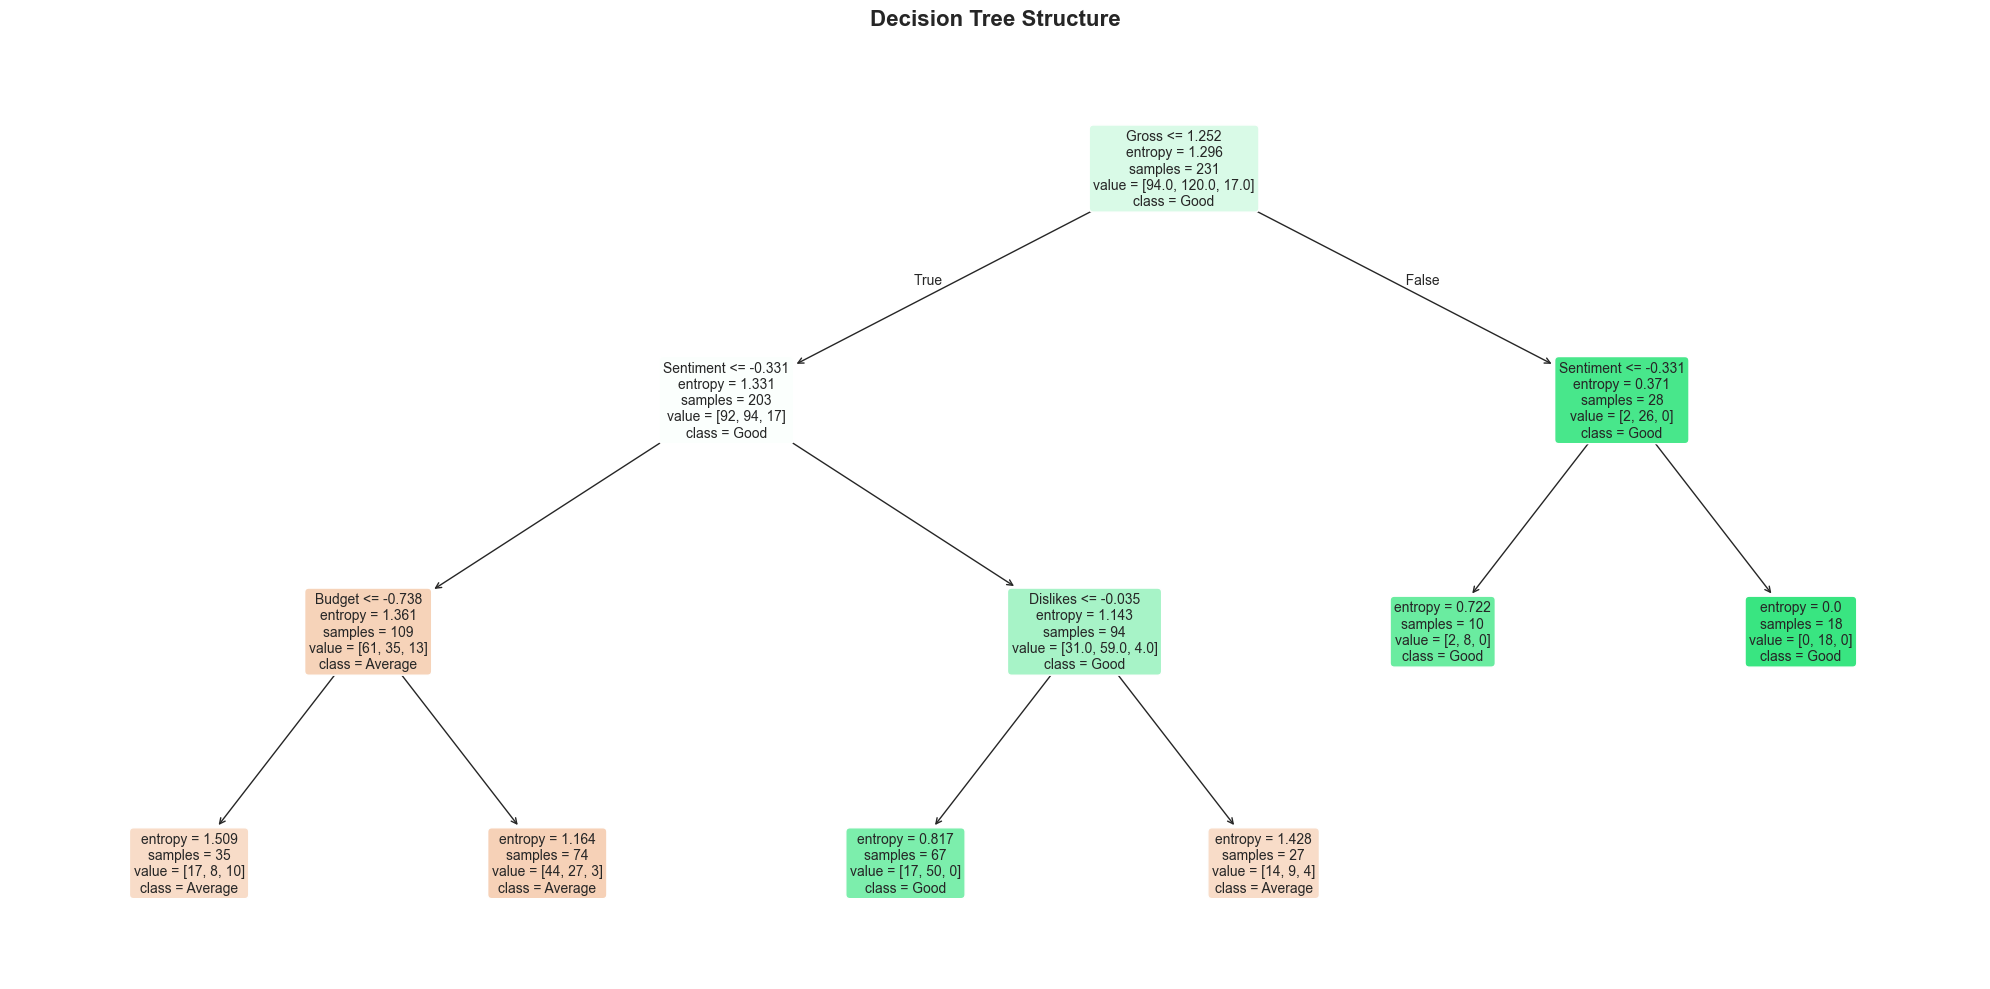


Tree visualization saved as 'decision_tree_structure.png'


In [52]:
print("DECISION TREE VISUALIZATION")

plt.figure(figsize=(20, 10))
plot_tree(
    dt_best,
    feature_names=feature_cols,
    class_names=le.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree Structure', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('decision_tree_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTree visualization saved as 'decision_tree_structure.png'")

In [53]:
# Extract decision rules
print("DECISION TREE RULES")

tree_rules = export_text(dt_best, feature_names=feature_cols)
print("\nDecision Rules:")
print("-" * 60)
print(tree_rules)

# Save rules to file
with open('decision_tree_rules.txt', 'w') as f:
    f.write("DECISION TREE CLASSIFICATION RULES\n")
    f.write("=" * 60 + "\n\n")
    f.write(tree_rules)

print("\nRules saved to 'decision_tree_rules.txt'")

DECISION TREE RULES

Decision Rules:
------------------------------------------------------------
|--- Gross <= 1.25
|   |--- Sentiment <= -0.33
|   |   |--- Budget <= -0.74
|   |   |   |--- class: 0
|   |   |--- Budget >  -0.74
|   |   |   |--- class: 0
|   |--- Sentiment >  -0.33
|   |   |--- Dislikes <= -0.03
|   |   |   |--- class: 1
|   |   |--- Dislikes >  -0.03
|   |   |   |--- class: 0
|--- Gross >  1.25
|   |--- Sentiment <= -0.33
|   |   |--- class: 1
|   |--- Sentiment >  -0.33
|   |   |--- class: 1


Rules saved to 'decision_tree_rules.txt'


DECISION TREE: FEATURE IMPORTANCE

Feature Importance:
----------------------------------------
  Gross                    : 0.3115
  Sentiment                : 0.2950
  Dislikes                 : 0.2370
  Budget                   : 0.1565


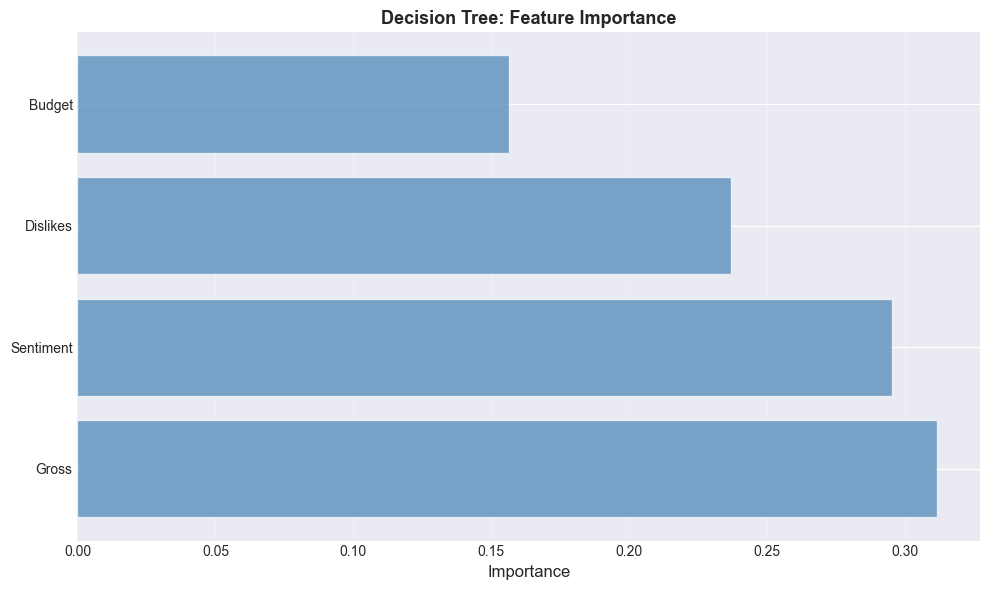


Number of features used: 4/12


In [54]:
# Feature importance from Decision Tree
print("DECISION TREE: FEATURE IMPORTANCE")

dt_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': dt_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print("-" * 40)
for idx, row in dt_importance.iterrows():
    if row['Importance'] > 0:
        print(f"  {row['Feature']:25s}: {row['Importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
features_used = dt_importance[dt_importance['Importance'] > 0]
plt.barh(features_used['Feature'], features_used['Importance'], color='steelblue', alpha=0.7)
plt.xlabel('Importance', fontsize=12)
plt.title('Decision Tree: Feature Importance', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\nNumber of features used: {(dt_best.feature_importances_ > 0).sum()}/{len(feature_cols)}")

---
## 4. Classifier #2: Support Vector Machine (SVM)

In [58]:
print("CLASSIFIER #2: SUPPORT VECTOR MACHINE (SVM)")

# Scale features for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"  Mean: {X_scaled.mean():.6f}")
print(f"  Std:  {X_scaled.std():.6f}")

# Define parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

print("\nParameter grid for tuning:")
for param, values in svm_param_grid.items():
    print(f"  {param}: {values}")

svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid=svm_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_scaled, y_encoded)

print(f"\nBest Parameters:")
for param, value in svm_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Accuracy: {svm_grid.best_score_:.4f}")

# Get best model
svm_best = svm_grid.best_estimator_

CLASSIFIER #2: SUPPORT VECTOR MACHINE (SVM)
  Mean: -0.000000
  Std:  1.000000

Parameter grid for tuning:
  C: [0.1, 1, 10, 100]
  kernel: ['linear', 'rbf', 'poly']
  gamma: ['scale', 'auto', 0.001, 0.01, 0.1]
Fitting 10 folds for each of 60 candidates, totalling 600 fits

Best Parameters:
  C: 1
  gamma: scale
  kernel: linear

Best Cross-Validation Accuracy: 0.5973


In [59]:
# Detailed cross-validation evaluation
print("SVM: DETAILED 10-FOLD CV EVALUATION")

# Perform cross-validation
svm_cv_results = cross_validate(
    svm_best, X_scaled, y_encoded,
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=True
)

print("\nCross-Validation Results (10 folds):")
print("-" * 60)

results_svm = {}

for metric in metrics:
    test_scores = svm_cv_results[f'test_{metric}']
    mean_score = test_scores.mean()
    std_score = test_scores.std()
    results_svm[metric] = {'mean': mean_score, 'std': std_score}

    print(f"{metric.upper():20s}: {mean_score:.4f} (+/- {std_score:.4f})")

SVM: DETAILED 10-FOLD CV EVALUATION

Cross-Validation Results (10 folds):
------------------------------------------------------------
ACCURACY            : 0.5973 (+/- 0.0807)
PRECISION_MACRO     : 0.3957 (+/- 0.0544)
RECALL_MACRO        : 0.4200 (+/- 0.0561)
F1_MACRO            : 0.4040 (+/- 0.0534)


In [60]:
# SVM model info
print("SVM MODEL INFORMATION")

print(f"\nKernel: {svm_best.kernel}")
print(f"Number of support vectors: {svm_best.n_support_}")
print(f"  Per class: {dict(zip(le.classes_, svm_best.n_support_))}")
print(f"Total support vectors: {svm_best.support_vectors_.shape[0]}")
print(f"Support vector ratio: {svm_best.support_vectors_.shape[0]/len(X):.2%}")

SVM MODEL INFORMATION

Kernel: linear
Number of support vectors: [85 84 17]
  Per class: {'Average': np.int32(85), 'Good': np.int32(84), 'Poor': np.int32(17)}
Total support vectors: 186
Support vector ratio: 80.52%


---
## 5. Classifier #3: Random Forest (Ensemble)

In [61]:
print("CLASSIFIER #3: RANDOM FOREST (ENSEMBLE)")

# Define parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("\nParameter grid for tuning:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X, y_encoded)

print(f"\nBest Parameters:")
for param, value in rf_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Accuracy: {rf_grid.best_score_:.4f}")

# Get best model
rf_best = rf_grid.best_estimator_

CLASSIFIER #3: RANDOM FOREST (ENSEMBLE)

Parameter grid for tuning:
  n_estimators: [50, 100, 200, 300]
  max_depth: [5, 10, 15, 20, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]
Fitting 10 folds for each of 540 candidates, totalling 5400 fits

Best Parameters:
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 4
  min_samples_split: 2
  n_estimators: 200

Best Cross-Validation Accuracy: 0.6409


In [62]:
# Detailed cross-validation evaluation
print("RANDOM FOREST: DETAILED 10-FOLD CV EVALUATION")

# Perform cross-validation
rf_cv_results = cross_validate(
    rf_best, X, y_encoded,
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=True
)

print("\nCross-Validation Results (10 folds):")
print("-" * 60)

results_rf = {}

for metric in metrics:
    test_scores = rf_cv_results[f'test_{metric}']
    mean_score = test_scores.mean()
    std_score = test_scores.std()
    results_rf[metric] = {'mean': mean_score, 'std': std_score}
    
    print(f"{metric.upper():20s}: {mean_score:.4f} (+/- {std_score:.4f})")

RANDOM FOREST: DETAILED 10-FOLD CV EVALUATION

Cross-Validation Results (10 folds):
------------------------------------------------------------
ACCURACY            : 0.6409 (+/- 0.0764)
PRECISION_MACRO     : 0.4250 (+/- 0.0498)
RECALL_MACRO        : 0.4524 (+/- 0.0548)
F1_MACRO            : 0.4332 (+/- 0.0546)


RANDOM FOREST: FEATURE IMPORTANCE

Feature Importance:
----------------------------------------
  Gross                    : 0.1430
  Sentiment                : 0.1268
  Budget                   : 0.1128
  Dislikes                 : 0.1110
  Screens                  : 0.0951
  Comments                 : 0.0942
  Likes                    : 0.0892
  Aggregate Followers      : 0.0804
  Views                    : 0.0712
  Genre                    : 0.0490
  Year                     : 0.0165
  Sequel                   : 0.0107


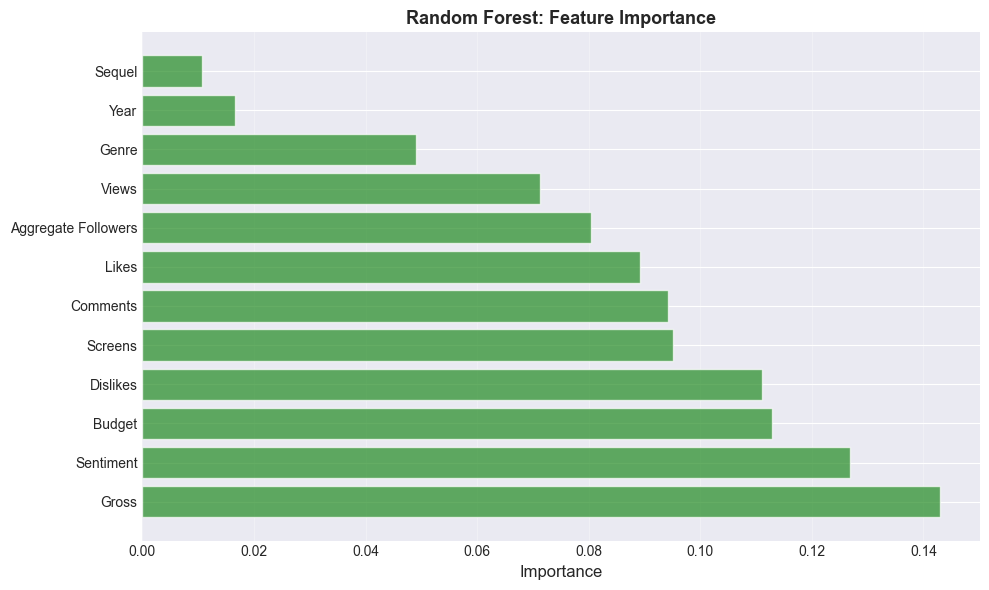

In [63]:
# Random Forest feature importance
print("RANDOM FOREST: FEATURE IMPORTANCE")

rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print("-" * 40)
for idx, row in rf_importance.iterrows():
    print(f"  {row['Feature']:25s}: {row['Importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_importance['Feature'], rf_importance['Importance'], color='forestgreen', alpha=0.7)
plt.xlabel('Importance', fontsize=12)
plt.title('Random Forest: Feature Importance', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---
## 6. Compare All Three Classifiers

In [64]:
print("PERFORMANCE COMPARISON: ALL CLASSIFIERS")

# Create comparison table
comparison_data = []

for classifier_name, results in [('Decision Tree', results_dt), 
                                  ('SVM', results_svm), 
                                  ('Random Forest', results_rf)]:
    row = {'Classifier': classifier_name}
    for metric in metrics:
        row[metric.replace('_', ' ').title()] = f"{results[metric]['mean']:.4f} ± {results[metric]['std']:.4f}"
        row[f"{metric}_mean"] = results[metric]['mean']
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("\nPerformance Metrics (Mean ± Std):")
print("-" * 80)
print(comparison_df[['Classifier', 'Accuracy', 'Precision Macro', 'Recall Macro', 'F1 Macro']].to_string(index=False))

# Find best classifier for each metric
print("BEST PERFORMING CLASSIFIER PER METRIC")

for metric in metrics:
    best_idx = comparison_df[f"{metric}_mean"].idxmax()
    best_classifier = comparison_df.loc[best_idx, 'Classifier']
    best_score = comparison_df.loc[best_idx, f"{metric}_mean"]
    print(f"{metric.upper():20s}: {best_classifier:15s} ({best_score:.4f})")

PERFORMANCE COMPARISON: ALL CLASSIFIERS

Performance Metrics (Mean ± Std):
--------------------------------------------------------------------------------
   Classifier        Accuracy Precision Macro    Recall Macro        F1 Macro
Decision Tree 0.6226 ± 0.1227 0.4567 ± 0.1579 0.4630 ± 0.1118 0.4506 ± 0.1267
          SVM 0.5973 ± 0.0807 0.3957 ± 0.0544 0.4200 ± 0.0561 0.4040 ± 0.0534
Random Forest 0.6409 ± 0.0764 0.4250 ± 0.0498 0.4524 ± 0.0548 0.4332 ± 0.0546
BEST PERFORMING CLASSIFIER PER METRIC
ACCURACY            : Random Forest   (0.6409)
PRECISION_MACRO     : Decision Tree   (0.4567)
RECALL_MACRO        : Decision Tree   (0.4630)
F1_MACRO            : Decision Tree   (0.4506)


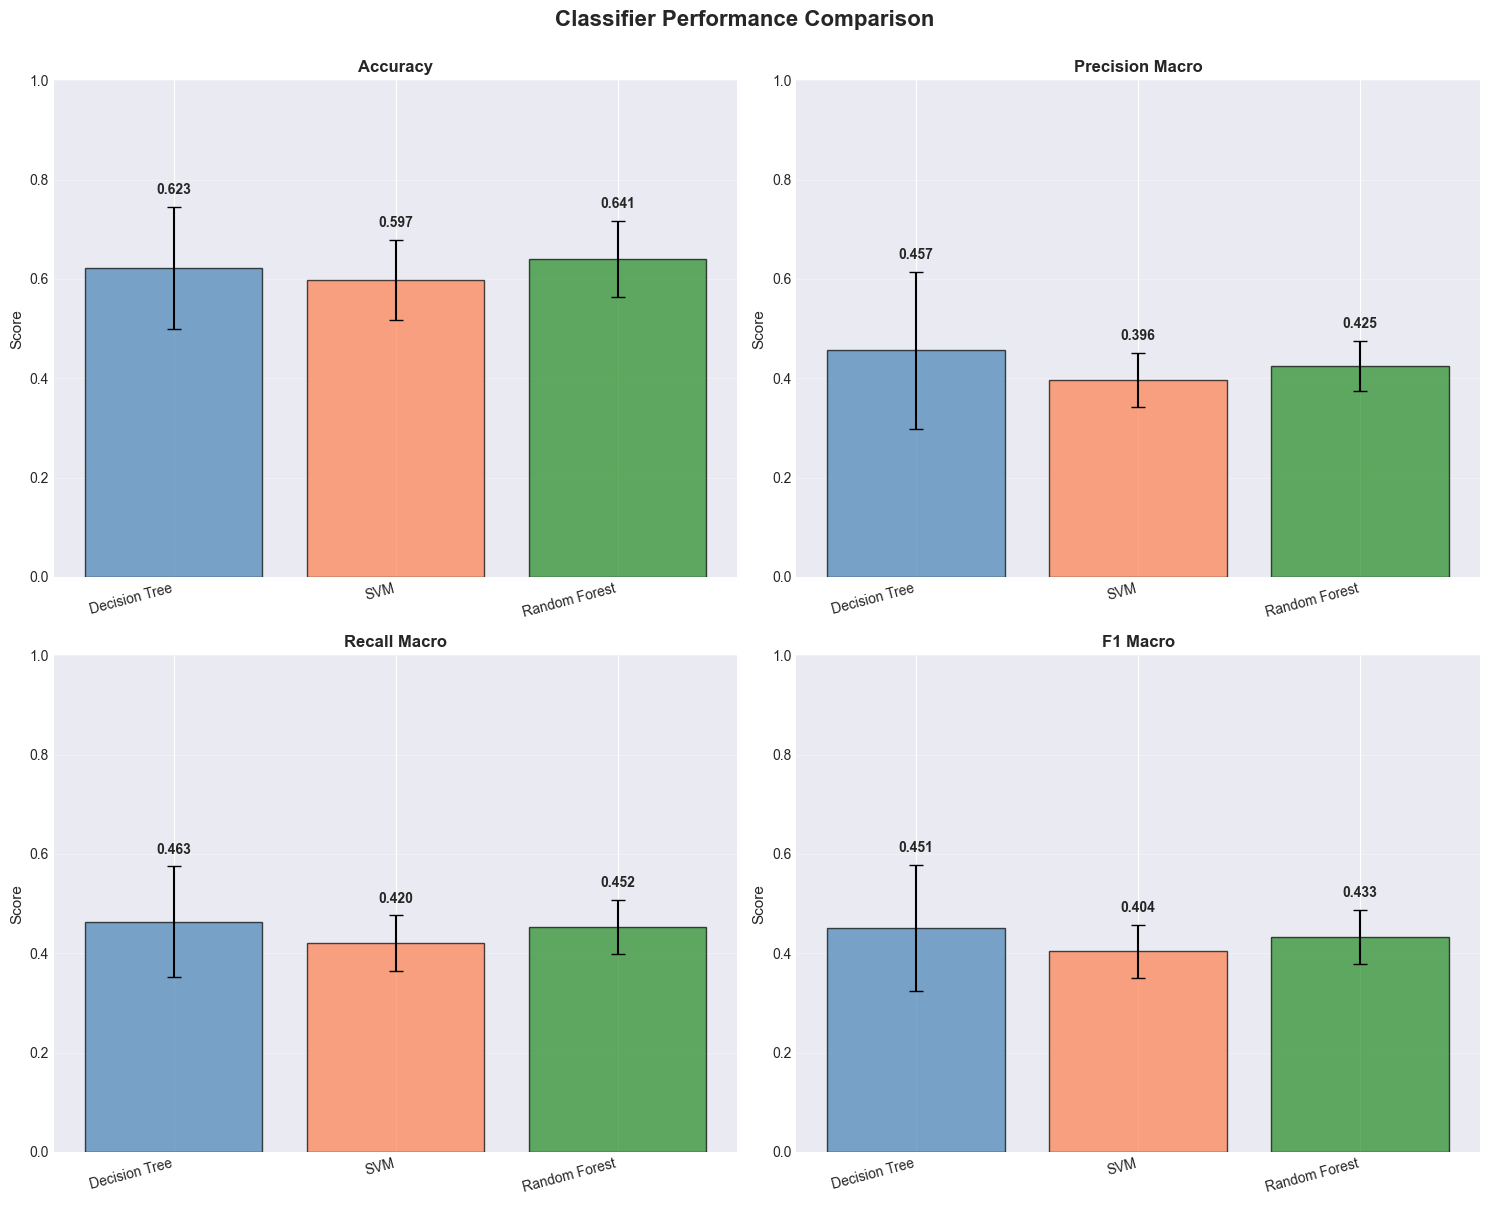

In [66]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Classifier Performance Comparison', fontsize=16, fontweight='bold', y=1.00)

classifiers = ['Decision Tree', 'SVM', 'Random Forest']
colors = ['steelblue', 'coral', 'forestgreen']

# Plot each metric
for idx, (metric, ax) in enumerate(zip(metrics, axes.flatten())):
    means = [results_dt[metric]['mean'], results_svm[metric]['mean'], results_rf[metric]['mean']]
    stds = [results_dt[metric]['std'], results_svm[metric]['std'], results_rf[metric]['std']]
    
    x_pos = np.arange(len(classifiers))
    ax.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, capsize=5, edgecolor='black')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(classifiers, rotation=15, ha='right')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax.text(i, mean + std + 0.02, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 7. Per-Class Performance Analysis

Since we have class imbalance (Poor: 7.8%, Average: 40.3%, Good: 51.9%),
it's important to analyze performance for each class separately.

In [67]:
print("PER-CLASS PERFORMANCE ANALYSIS")

# Train models on full dataset for final evaluation
# (in practice, use train/test split, but for consistency with CV results we use full data)

# Decision Tree
dt_best.fit(X, y_encoded)
dt_pred = dt_best.predict(X)

# SVM
svm_best.fit(X_scaled, y_encoded)
svm_pred = svm_best.predict(X_scaled)

# Random Forest
rf_best.fit(X, y_encoded)
rf_pred = rf_best.predict(X)

# Print classification reports
models = [
    ('Decision Tree', y_encoded, dt_pred),
    ('SVM', y_encoded, svm_pred),
    ('Random Forest', y_encoded, rf_pred)
]

for model_name, y_true, y_pred in models:
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} - CLASSIFICATION REPORT")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))

PER-CLASS PERFORMANCE ANALYSIS

DECISION TREE - CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Average     0.5515    0.7979    0.6522        94
        Good     0.8000    0.6333    0.7070       120
        Poor     0.0000    0.0000    0.0000        17

    accuracy                         0.6537       231
   macro avg     0.4505    0.4771    0.4531       231
weighted avg     0.6400    0.6537    0.6326       231


SVM - CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Average     0.5909    0.5532    0.5714        94
        Good     0.6831    0.8083    0.7405       120
        Poor     1.0000    0.0588    0.1111        17

    accuracy                         0.6494       231
   macro avg     0.7580    0.4734    0.4743       231
weighted avg     0.6689    0.6494    0.6254       231


RANDOM FOREST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Average     0.8738    0.9574    0.9137  

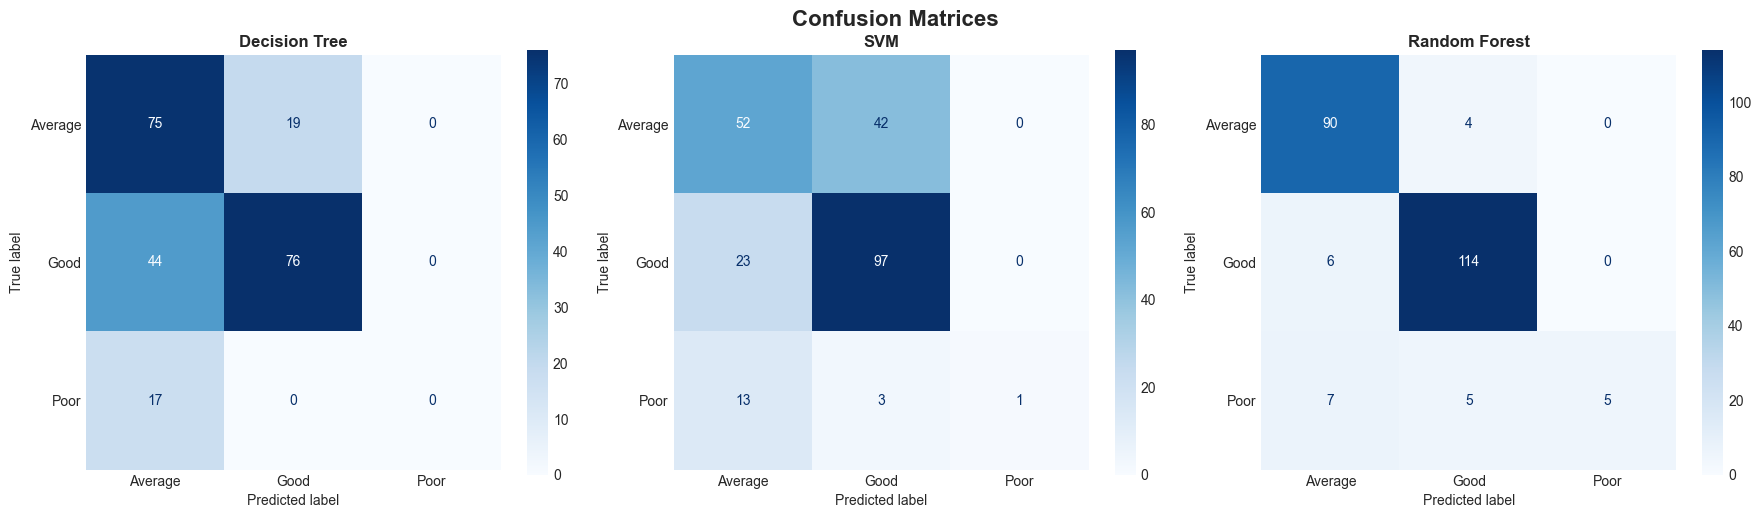

In [68]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

for idx, (model_name, y_true, y_pred, ax) in enumerate(zip(
    ['Decision Tree', 'SVM', 'Random Forest'],
    [y_encoded, y_encoded, y_encoded],
    [dt_pred, svm_pred, rf_pred],
    axes
)):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(model_name, fontsize=12, fontweight='bold')
    ax.grid(False)

plt.tight_layout()
plt.show()